In [1]:
import os
import time
import datetime
import itertools
import cartopy
import matplotlib
import tqdm
import csv 
import geopandas as gpd
import rasterio as rio
import fiona
#from mpl_toolkits.basemap import Basemap

import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gp
from sklearn.preprocessing import MinMaxScaler
sns.set()
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches

import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt

from matplotlib.lines import Line2D
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

#from descartes import PolygonPatch
from itertools import combinations
from collections import OrderedDict 

import datetime as dt
import xarray as xr
import rioxarray

from shapely.geometry import mapping

/Users/mmorphew/opt/anaconda3/envs/wxee/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [35]:
gsa_shape = gp.read_file('../shape/i03_Groundwater_Sustainability_Plan_Areas_MapService.shp')

In [36]:
gsa_shape.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 117 entries, 0 to 116
Data columns (total 20 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    117 non-null    int64   
 1   GSP_ID      117 non-null    int64   
 2   Loc_GSP_ID  35 non-null     object  
 3   Basin_Numb  117 non-null    object  
 4   Basin_Subb  117 non-null    object  
 5   Basin_Name  117 non-null    object  
 6   Basin_Su_1  117 non-null    object  
 7   Pln_Mngr    117 non-null    object  
 8   PM_Email    117 non-null    object  
 9   POC         35 non-null     object  
 10  Submitted   117 non-null    object  
 11  Date_Poste  117 non-null    object  
 12  UPDATED_DT  117 non-null    object  
 13  Status      117 non-null    object  
 14  GSA_IDs     117 non-null    object  
 15  COMMENTS    0 non-null      object  
 16  MODIFIED_B  117 non-null    object  
 17  ShapeSTAre  117 non-null    float64 
 18  ShapeSTLen  117 non-null    float64 
 19  

In [22]:
# County of Butte GSA 2 - 251
# Reclamation District 2106 - 195
# Western Canal District GSA - 120
# Butte Water District GSA - 417
# Richville Irrigation District - 112
# Biggs-West Gridley Water District - 117
# Reclamation District 1004 - 416
# County of Glenn, Butte - 415

In [34]:
butte_shapes = gsa_shape[gsa_shape['GSA_ID'].isin([251,195,120,417,112,117,173,415,416, 128, 467])]

In [35]:
butte_new_shape = butte_shapes.geometry.unary_union


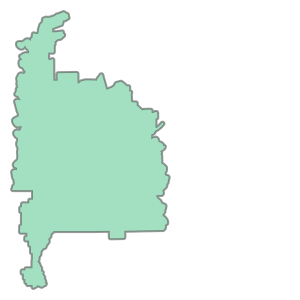

In [53]:
butte_new_shape.buffer(500)

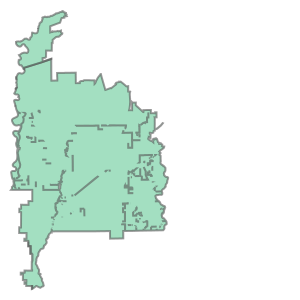

In [43]:
butte_new_shape

<AxesSubplot:>

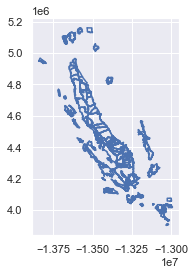

In [37]:
gsa_shape.boundary.plot()

In [38]:
cv_shape = gp.read_file('../shape/Alluvial_Bnd.shp')

<AxesSubplot:>

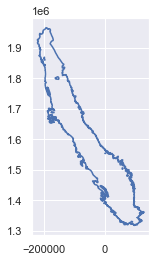

In [39]:
cv_shape.boundary.plot()

In [40]:
cv_shape.to_crs(3310, inplace=True)

In [41]:
gsa_shape.to_crs(3310, inplace=True)

In [42]:
cv_shape['geometry'] = cv_shape.geometry.buffer(10000)

In [47]:
gsa_cv = gsa_shape.within(cv_shape.loc[0, 'geometry'])
gsa_cv = gsa_shape.loc[gsa_cv]
print(len(np.unique(gsa_cv["GSP_ID"])))

62


<AxesSubplot:>

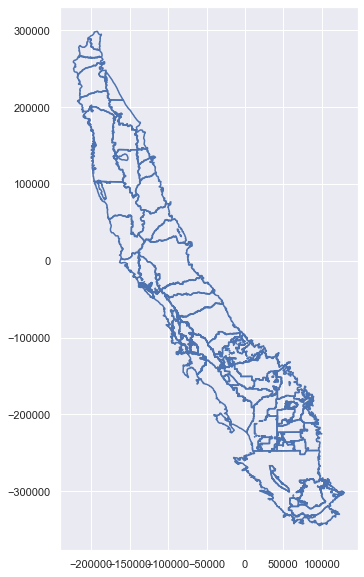

In [45]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
gsa_cv.boundary.plot(ax=ax)

In [12]:
gsa_cv.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 194 entries, 0 to 349
Data columns (total 23 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    194 non-null    int64   
 1   GSA_ID      194 non-null    int64   
 2   GSA_Name    194 non-null    object  
 3   Loc_GSA_ID  9 non-null      object  
 4   Basin_Name  194 non-null    object  
 5   Posted_DT   194 non-null    object  
 6   GSA_URL     108 non-null    object  
 7   POC_Name    188 non-null    object  
 8   POC_Phone   188 non-null    object  
 9   POC_Email   188 non-null    object  
 10  Date_90_Da  194 non-null    object  
 11  Exclusive   194 non-null    object  
 12  Overlap     194 non-null    object  
 13  GSP_ID      194 non-null    int64   
 14  COMMENTS    0 non-null      object  
 15  Basin_Numb  194 non-null    object  
 16  Basin_Subb  194 non-null    object  
 17  Basin_Su_1  194 non-null    object  
 18  UPDATED_DT  194 non-null    object  
 19  

Process that needs to be automated:
1. Select a GSA, cut out its shapefile
2. Query EarthEngine for that GSA's ET data, save to time series.
3. Perform some statistial analysis on the relative differences between the data.

Things I want to make
1. Make a map of ET variance
2. Make a map of highest ET model in each GSA
3. Make a map of lowest ET model in each GSA

In [13]:
unique_GSA_Name = pd.unique(gsa_cv['GSA_Name'])

In [14]:
np.min(gsa_cv['ShapeSTAre'])

618872.862963765

In [15]:
np.max(gsa_cv['ShapeSTAre'])

3830282092.6863074

In [16]:
pd.unique(gsa_cv['Exclusive'])

array(['Yes', 'No'], dtype=object)

In [17]:
gsa_cv_cleaned = gsa_cv

In [18]:
gsa_cv_cleaned.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 194 entries, 0 to 349
Data columns (total 23 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    194 non-null    int64   
 1   GSA_ID      194 non-null    int64   
 2   GSA_Name    194 non-null    object  
 3   Loc_GSA_ID  9 non-null      object  
 4   Basin_Name  194 non-null    object  
 5   Posted_DT   194 non-null    object  
 6   GSA_URL     108 non-null    object  
 7   POC_Name    188 non-null    object  
 8   POC_Phone   188 non-null    object  
 9   POC_Email   188 non-null    object  
 10  Date_90_Da  194 non-null    object  
 11  Exclusive   194 non-null    object  
 12  Overlap     194 non-null    object  
 13  GSP_ID      194 non-null    int64   
 14  COMMENTS    0 non-null      object  
 15  Basin_Numb  194 non-null    object  
 16  Basin_Subb  194 non-null    object  
 17  Basin_Su_1  194 non-null    object  
 18  UPDATED_DT  194 non-null    object  
 19  

In [19]:
gsa_cv_cleaned[gsa_cv_cleaned['GSA_Name'] == 'Wyandotte Creek GSA']

,OBJECTID,GSA_ID,GSA_Name,Loc_GSA_ID,Basin_Name,Posted_DT,GSA_URL,POC_Name,POC_Phone,POC_Email,...,GSP_ID,COMMENTS,Basin_Numb,Basin_Subb,Basin_Su_1,UPDATED_DT,MODIFIED_B,ShapeSTAre,ShapeSTLen,geometry
7,8,406,Wyandotte Creek GSA,None,SACRAMENTO VALLEY,05/17/2019,http://www.buttecounty.net/waterresourceconser...,Christina Buck,530-552-3593,cbuck@buttecounty.net,...,99,None,5-021,5-021.69,SACRAMENTO VALLEY - WYANDOTTE CREEK,2021-10-25,Mark Nordberg,4.031575e+08,131479.562962,"POLYGON ((-131592.012 167336.786, -131496.768 ..."


In [20]:
wyandotte = gsa_cv_cleaned[gsa_cv_cleaned['GSA_Name'] == 'Wyandotte Creek GSA']
wyandotte.area/1000000

7    240.275213
dtype: float64

In [21]:
gsa_cv_cleaned_no_small = gsa_cv_cleaned[gsa_cv_cleaned['ShapeSTAre'] > 4e8]

In [22]:
gsa_cv_cleaned_no_small['GSA_Name'].unique()

array(['Wyandotte Creek GSA', 'El Rico GSA',
       'Madera Irrigation District GSA',
       'Central San Joaquin Water Conservation District GSA',
       'Glenn Groundwater Authority GSA', 'Mid-Kings River GSA',
       'Merced Subbasin GSA', 'Sacramento Groundwater Authority GSA',
       'Merced Irrigation-Urban GSA',
       'North San Joaquin Water Conservation District GSA',
       'Colusa Groundwater Authority GSA - Colusa', 'McMullin Area GSA',
       'Semitropic Water Storage District GSA',
       'Eastside San Joaquin GSA',
       'San Joaquin River Exchange Contractors GSA',
       'South Sutter Water District GSA', 'North Fork Kings GSA',
       'Kings River East GSA', 'Eastern Tule GSA',
       'Westlands Water District GSA',
       'Lower Tule River Irrigation District GSA', 'East Kaweah GSA',
       'Stockton East Water District GSA',
       'Pixley Irrigation District GSA', 'South Fork Kings GSA',
       'Chowchilla Water District GSA', 'Grasslands GSA',
       'County of 

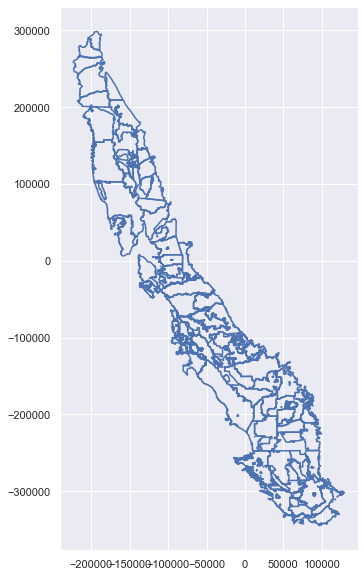

In [23]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
gsa_cv_cleaned_no_small.boundary.plot(ax=ax)
y_min, y_max = ax.get_ylim()
x_min, x_max = ax.get_xlim()

In [24]:
gsa_names = np.unique(gsa_cv_cleaned_no_small['GSA_Name'])

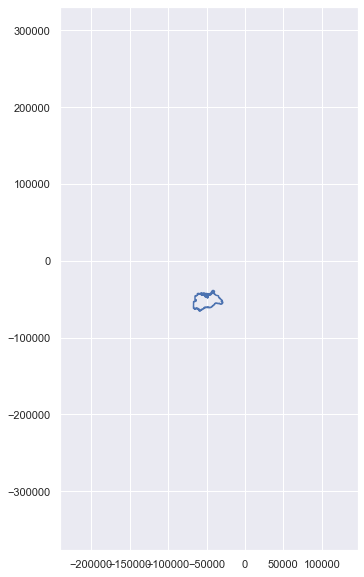

In [25]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
plt.xlim(x_min,x_max)
plt.ylim(y_min,y_max)
gsa_cv_cleaned_no_small[gsa_cv_cleaned_no_small['GSA_Name']==gsa_names[10]].boundary.plot(ax=ax)

In [36]:
for index, row in gsa_cv_cleaned_no_small.iterrows():
    print(row['GSA_Name'], row['GSA_ID'])
    print(row.ShapeSTAre)

Wyandotte Creek GSA 406
403157528.6547368
El Rico GSA 358
1417954054.1865654
Madera Irrigation District GSA 19
849444304.448105
Central San Joaquin Water Conservation District GSA 189
476551376.28020006
Glenn Groundwater Authority GSA 369
2084191454.4643245
Mid-Kings River GSA 73
608511094.3746209
Merced Subbasin GSA 219
2161114377.8253713
Sacramento Groundwater Authority GSA 118
814974473.8694183
Merced Irrigation-Urban GSA 311
1042746305.4982576
North San Joaquin Water Conservation District GSA 159
977853103.7167923
Colusa Groundwater Authority GSA - Colusa 323
2806645308.355041
McMullin Area GSA 266
759502464.0179878
Semitropic Water Storage District GSA 277
1376240920.878579
Eastside San Joaquin GSA 288
825421452.910605
San Joaquin River Exchange Contractors GSA 10
1625535279.7151487
South Sutter Water District GSA 233
443002292.6128773
North Fork Kings GSA 187
1055059016.7552731
Kings River East GSA 18
1202998384.0932455
Eastern Tule GSA 205
995470291.7527624
Westlands Water Distr

In [32]:
sample = gsa_cv_cleaned_no_small[gsa_cv_cleaned_no_small['GSA_Name']==gsa_names[0]]

In [33]:
sample

,OBJECTID,GSA_ID,GSA_Name,Loc_GSA_ID,Basin_Name,Posted_DT,GSA_URL,POC_Name,POC_Phone,POC_Email,...,GSP_ID,COMMENTS,Basin_Numb,Basin_Subb,Basin_Su_1,UPDATED_DT,MODIFIED_B,ShapeSTAre,ShapeSTLen,geometry
309,310,481,Arvin GSA,None,SAN JOAQUIN VALLEY,12/03/2021,www.aewsd.org,Jeevan Muhar,661-854-5573,jmuhar@aewsd.org,...,150,None,5-022,5-022.14,SAN JOAQUIN VALLEY - KERN COUNTY,2021-12-03,Mark Nordberg,6.538968e+08,245367.521789,"MULTIPOLYGON (((102217.096 -294387.717, 102197..."


In [38]:
sample.bounds

,minx,miny,maxx,maxy
309,86794.158524,-330154.215143,128757.34857,-290722.417109


In [42]:
float(sample.bounds['minx'])

86794.15852398136

In [47]:
sample.to_crs(4326).bounds

,minx,miny,maxx,maxy
309,-119.047293,35.041391,-118.583091,35.394656


In [5]:
cropland_1_1 = xr.open_dataset("../data/cropland/cropland_2000_2020_test_3_1_1.nc")
cropland_1_2 = xr.open_dataset("../data/cropland/cropland_2000_2020_test_3_1_2.nc")
cropland_1_3 = xr.open_dataset("../data/cropland/cropland_2000_2020_test_3_1_3.nc")
cropland_1_4 = xr.open_dataset("../data/cropland/cropland_2000_2020_test_3_1_4.nc")

cropland_1_2 = cropland_1_2.drop_isel(y=-1)
cropland_1_3 = cropland_1_3.drop_isel(y=-1)
cropland_1_4 = cropland_1_4.drop_isel(y=-1)
cropland_1 = xr.merge([cropland_1_1, cropland_1_2, cropland_1_3, cropland_1_4])

AttributeError: 'Dataset' object has no attribute 'drop_isel'

In [26]:
cropland_2_1 = xr.open_dataset("../data/cropland/cropland_2000_2020_test_3_2_1.nc")
cropland_2_2 = xr.open_dataset("../data/cropland/cropland_2000_2020_test_3_2_2.nc")
cropland_2_3 = xr.open_dataset("../data/cropland/cropland_2000_2020_test_3_2_3.nc")
cropland_2_4 = xr.open_dataset("../data/cropland/cropland_2000_2020_test_3_2_4.nc")

cropland_2_2 = cropland_2_2.drop_isel(y=-1)
cropland_2_3 = cropland_2_3.drop_isel(y=-1)
cropland_2_4 = cropland_2_4.drop_isel(y=-1)
cropland_2 = xr.merge([cropland_2_1, cropland_2_2, cropland_2_3, cropland_2_4])

In [28]:
cropland_3_1 = xr.open_dataset("../data/cropland/cropland_2000_2020_test_3_3_1.nc")
cropland_3_2 = xr.open_dataset("../data/cropland/cropland_2000_2020_test_3_3_2.nc")
cropland_3_3 = xr.open_dataset("../data/cropland/cropland_2000_2020_test_3_3_3.nc")
cropland_3_4 = xr.open_dataset("../data/cropland/cropland_2000_2020_test_3_3_4.nc")

cropland_3_2 = cropland_3_2.drop_isel(y=-1)
cropland_3_3 = cropland_3_3.drop_isel(y=-1)
cropland_3_4 = cropland_3_4.drop_isel(y=-1)
cropland_3 = xr.merge([cropland_3_1, cropland_3_2, cropland_3_3, cropland_3_4])

In [30]:
cropland_4_1 = xr.open_dataset("../data/cropland/cropland_2000_2020_test_3_4_1.nc")
cropland_4_2 = xr.open_dataset("../data/cropland/cropland_2000_2020_test_3_4_2.nc")
cropland_4_3 = xr.open_dataset("../data/cropland/cropland_2000_2020_test_3_4_3.nc")
cropland_4_4 = xr.open_dataset("../data/cropland/cropland_2000_2020_test_3_4_4.nc")

cropland_4_2 = cropland_4_2.drop_isel(y=-1)
cropland_4_3 = cropland_4_3.drop_isel(y=-1)
cropland_4_4 = cropland_4_4.drop_isel(y=-1)
cropland_4 = xr.merge([cropland_4_1, cropland_4_2, cropland_4_3, cropland_4_4])

In [32]:
cropland_total = xr.merge([cropland_1, cropland_2, cropland_3, cropland_4])

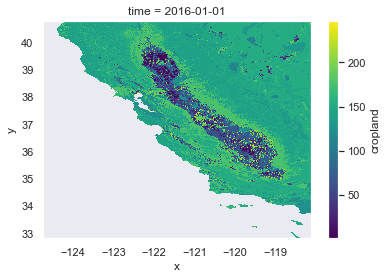

In [33]:
cropland_total["cropland"].isel(time=16).plot()

In [34]:
cropland_total.to_netcdf("~/Desktop/cropland_combined_3.nc")

In [2]:
soil_moisture_1_1 = xr.open_dataset("../data/cropland/soil_moisture_2015_2020_1_1.nc")
soil_moisture_1_2 = xr.open_dataset("../data/cropland/soil_moisture_2015_2020_1_2.nc")
soil_moisture_1_3 = xr.open_dataset("../data/cropland/soil_moisture_2015_2020_1_3.nc")
soil_moisture_1_4 = xr.open_dataset("../data/cropland/soil_moisture_2015_2020_1_4.nc")

soil_moisture_1_2 = soil_moisture_1_2.drop_isel(y=-1)
soil_moisture_1_3 = soil_moisture_1_3.drop_isel(y=-1)
soil_moisture_1_4 = soil_moisture_1_4.drop_isel(y=-1)
soil_moisture_1 = xr.merge([soil_moisture_1_1, soil_moisture_1_2, soil_moisture_1_3, soil_moisture_1_4])

In [3]:
soil_moisture_2_1 = xr.open_dataset("../data/cropland/soil_moisture_2015_2020_2_1.nc")
soil_moisture_2_2 = xr.open_dataset("../data/cropland/soil_moisture_2015_2020_2_2.nc")
soil_moisture_2_3 = xr.open_dataset("../data/cropland/soil_moisture_2015_2020_2_3.nc")
soil_moisture_2_4 = xr.open_dataset("../data/cropland/soil_moisture_2015_2020_2_4.nc")

soil_moisture_2_2 = soil_moisture_2_2.drop_isel(y=-1)
soil_moisture_2_3 = soil_moisture_2_3.drop_isel(y=-1)
soil_moisture_2_4 = soil_moisture_2_4.drop_isel(y=-1)
soil_moisture_2 = xr.merge([soil_moisture_2_1, soil_moisture_2_2, soil_moisture_2_3, soil_moisture_2_4])

In [4]:
soil_moisture_3_1 = xr.open_dataset("../data/cropland/soil_moisture_2015_2020_3_1.nc")
soil_moisture_3_2 = xr.open_dataset("../data/cropland/soil_moisture_2015_2020_3_2.nc")
soil_moisture_3_3 = xr.open_dataset("../data/cropland/soil_moisture_2015_2020_3_3.nc")
soil_moisture_3_4 = xr.open_dataset("../data/cropland/soil_moisture_2015_2020_3_4.nc")

soil_moisture_3_2 = soil_moisture_3_2.drop_isel(y=-1)
soil_moisture_3_3 = soil_moisture_3_3.drop_isel(y=-1)
soil_moisture_3_4 = soil_moisture_3_4.drop_isel(y=-1)
soil_moisture_3 = xr.merge([soil_moisture_3_1, soil_moisture_3_2, soil_moisture_3_3, soil_moisture_3_4])

In [5]:
soil_moisture_4_1 = xr.open_dataset("../data/cropland/soil_moisture_2015_2020_4_1.nc")
soil_moisture_4_2 = xr.open_dataset("../data/cropland/soil_moisture_2015_2020_4_2.nc")
soil_moisture_4_3 = xr.open_dataset("../data/cropland/soil_moisture_2015_2020_4_3.nc")
soil_moisture_4_4 = xr.open_dataset("../data/cropland/soil_moisture_2015_2020_4_4.nc")

soil_moisture_4_2 = soil_moisture_4_2.drop_isel(y=-1)
soil_moisture_4_3 = soil_moisture_4_3.drop_isel(y=-1)
soil_moisture_4_4 = soil_moisture_4_4.drop_isel(y=-1)
soil_moisture_4 = xr.merge([soil_moisture_4_1, soil_moisture_4_2, soil_moisture_4_3, soil_moisture_4_4])

In [6]:
soil_moisture_total = xr.merge([soil_moisture_1, soil_moisture_2, soil_moisture_3, soil_moisture_4])

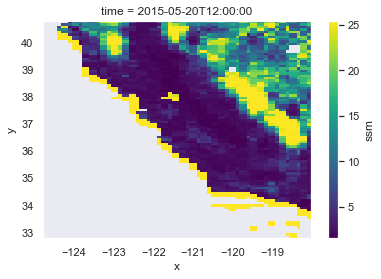

In [10]:
soil_moisture_total["ssm"].isel(time=16).plot()

In [11]:
soil_moisture_total.to_netcdf("~/Desktop/soil_moisture_combined.nc")